In [12]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from typing import Tuple, List
import random
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from PIL import Image, ImageDraw, ImageFont
import nltk
from nltk.corpus import words
import string
from torchvision import transforms

In [13]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: MPS


### Question 4.1

In [6]:
# 4.1.1 Dataset Generation
def generate_sequences(num_sequences, min_length=1, max_length=16):
    sequences = []
    counts = []
    
    for _ in range(num_sequences):
        length = np.random.randint(min_length, max_length + 1)
        sequence = np.random.randint(0, 2, size=length)
        count = np.sum(sequence)
        sequences.append(sequence)
        counts.append(count)
    
    return sequences, counts

class BitCountDataset(Dataset):
    def __init__(self, sequences, counts):
        self.sequences = sequences
        self.counts = counts
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = torch.FloatTensor(self.sequences[idx])
        count = torch.FloatTensor([self.counts[idx]])
        return seq, count

def collate_fn(batch):
    # Separate sequences and counts
    sequences = [item[0] for item in batch]
    counts = [item[1] for item in batch]
    
    # Pad sequences to the same length
    sequences_padded = pad_sequence(sequences, batch_first=True)
    counts = torch.stack(counts)
    
    return sequences_padded, counts

# Generate dataset
sequences, counts = generate_sequences(100000)

# Split dataset
train_seq, temp_seq, train_counts, temp_counts = train_test_split(sequences, counts, test_size=0.2, random_state=42)
val_seq, test_seq, val_counts, test_counts = train_test_split(temp_seq, temp_counts, test_size=0.5, random_state=42)

# Create datasets
train_dataset = BitCountDataset(train_seq, train_counts)
val_dataset = BitCountDataset(val_seq, val_counts)
test_dataset = BitCountDataset(test_seq, test_counts)

# Create dataloaders with collate_fn
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

# 4.1.2 RNN Architecture
class BitCountRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(BitCountRNN, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = x.unsqueeze(-1) if x.dim() == 2 else x  # Add feature dimension
        output, _ = self.rnn(x)
        return self.fc(output[:, -1, :])

# 4.1.3 Training Loop
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.L1Loss()  # MAE loss
    optimizer = torch.optim.Adam(model.parameters())
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, counts in train_loader:
            sequences, counts = sequences.to(device), counts.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, counts)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, counts in val_loader:
                sequences, counts = sequences.to(device), counts.to(device)
                outputs = model(sequences)
                val_loss += criterion(outputs, counts).item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training MAE: {train_loss:.4f}')
        print(f'Validation MAE: {val_loss:.4f}')
    
    return train_losses, val_losses

# Random baseline
def random_baseline(sequences, counts):
    predictions = [np.random.randint(0, len(seq)+1) for seq in sequences]
    mae = np.mean(np.abs(np.array(predictions) - np.array(counts)))
    return mae

# 4.1.4 Generalization Test
def test_generalization(model, max_length=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    mae_by_length = {}
    
    for length in range(1, max_length + 1):
        # Generate test sequences of specific length
        test_sequences, test_counts = generate_sequences(1000, length, length)
        test_dataset = BitCountDataset(test_sequences, test_counts)
        test_loader = DataLoader(test_dataset, batch_size=32)
        
        total_mae = 0
        with torch.no_grad():
            for sequences, counts in test_loader:
                sequences, counts = sequences.to(device), counts.to(device)
                outputs = model(sequences)
                mae = nn.L1Loss()(outputs, counts).item()
                total_mae += mae
        
        mae_by_length[length] = total_mae / len(test_loader)
    
    return mae_by_length

Starting training...
Epoch 1/20:
Training MAE: 0.5064
Validation MAE: 0.0772
Epoch 2/20:
Training MAE: 0.1171
Validation MAE: 0.1387
Epoch 3/20:
Training MAE: 0.0883
Validation MAE: 0.0322
Epoch 4/20:
Training MAE: 0.0668
Validation MAE: 0.0325
Epoch 5/20:
Training MAE: 0.0479
Validation MAE: 0.0219
Epoch 6/20:
Training MAE: 0.0358
Validation MAE: 0.0174
Epoch 7/20:
Training MAE: 0.0294
Validation MAE: 0.0380
Epoch 8/20:
Training MAE: 0.0242
Validation MAE: 0.0126
Epoch 9/20:
Training MAE: 0.0249
Validation MAE: 0.0268
Epoch 10/20:
Training MAE: 0.0183
Validation MAE: 0.0083
Epoch 11/20:
Training MAE: 0.0408
Validation MAE: 0.0098
Epoch 12/20:
Training MAE: 0.0147
Validation MAE: 0.0107
Epoch 13/20:
Training MAE: 0.0200
Validation MAE: 0.0097
Epoch 14/20:
Training MAE: 0.0112
Validation MAE: 0.0074
Epoch 15/20:
Training MAE: 0.0097
Validation MAE: 0.0082
Epoch 16/20:
Training MAE: 0.0166
Validation MAE: 0.0140
Epoch 17/20:
Training MAE: 0.0174
Validation MAE: 0.0054
Epoch 18/20:
Traini

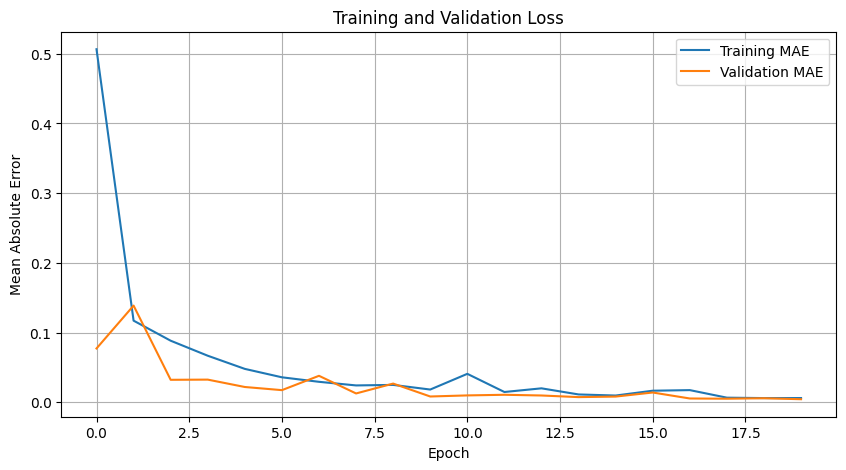


Calculating random baseline...
Random Baseline MAE: 2.5557

Testing generalization...


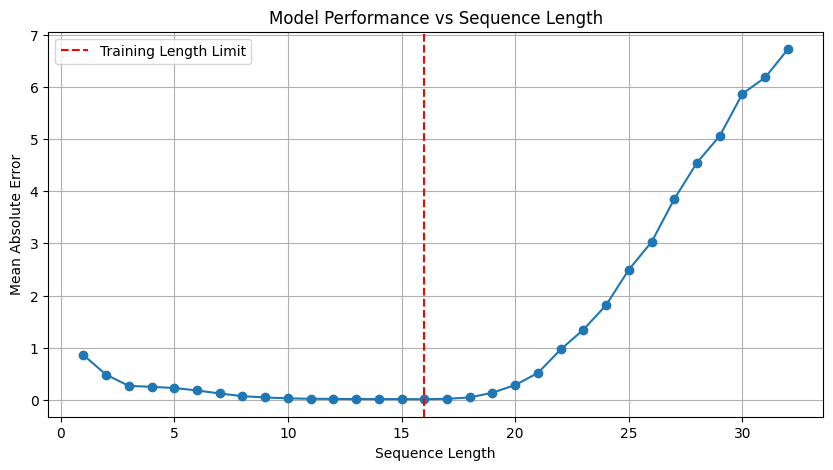


Example predictions:
Sequence: [1 1]
True count: 2
Predicted count: 2.85
Absolute Error: 0.85

Sequence: [0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 0]
True count: 8
Predicted count: 8.00
Absolute Error: 0.00

Sequence: [1 1 0 0 1]
True count: 3
Predicted count: 2.70
Absolute Error: 0.30

Sequence: [1 1]
True count: 2
Predicted count: 2.85
Absolute Error: 0.85

Sequence: [0 0 0 0 1 1 0]
True count: 2
Predicted count: 2.20
Absolute Error: 0.20

Model saved successfully!


In [4]:
if __name__ == "__main__":
    # Initialize model
    model = BitCountRNN().to(device)
    
    # Train model
    print("Starting training...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20)
    print("Training completed!")
    
    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training MAE')
    plt.plot(val_losses, label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curves.png')
    plt.show()
    
    # Calculate random baseline
    print("\nCalculating random baseline...")
    baseline_mae = random_baseline(test_seq, test_counts)
    print(f'Random Baseline MAE: {baseline_mae:.4f}')
    
    # Test generalization
    print("\nTesting generalization...")
    mae_by_length = test_generalization(model)
    
    # Plot generalization results
    plt.figure(figsize=(10, 5))
    lengths = list(mae_by_length.keys())
    maes = list(mae_by_length.values())
    plt.plot(lengths, maes, marker='o')
    plt.axvline(x=16, color='r', linestyle='--', label='Training Length Limit')
    plt.xlabel('Sequence Length')
    plt.ylabel('Mean Absolute Error')
    plt.title('Model Performance vs Sequence Length')
    plt.legend()
    plt.grid(True)
    plt.savefig('generalization_results.png')
    plt.show()

    # Print some example predictions
    print("\nExample predictions:")
    model.eval()
    # Move model to CPU for predictions
    model = model.cpu()
    with torch.no_grad():
        for i in range(5):
            seq = test_seq[i]
            true_count = test_counts[i]
            # Process on CPU
            seq_tensor = torch.FloatTensor(seq).unsqueeze(0)
            try:
                pred = model(seq_tensor)
                print(f'Sequence: {seq}')
                print(f'True count: {true_count}')
                print(f'Predicted count: {pred.item():.2f}')
                print(f'Absolute Error: {abs(pred.item() - true_count):.2f}\n')
            except RuntimeError as e:
                print(f"Error processing sequence {i}: {e}")
                continue

    # Save the model
    try:
        torch.save(model.state_dict(), '53_bit_counting_model.pth')
        print("Model saved successfully!")
    except Exception as e:
        print(f"Error saving model: {e}")

### Question 4.2

[nltk_data] Downloading package words to /Users/dikshant/nltk_data...
[nltk_data]   Package words is already up-to-date!


Using device: mps
Creating dataset...
Calculating random baseline...
Random Baseline Accuracy: 0.0112
Creating model...
Starting training...
Epoch: 1, Batch: 0, Loss: 4.5526
Epoch: 1, Batch: 100, Loss: 2.8447
Epoch: 1, Batch: 200, Loss: 2.8228
Epoch: 1, Batch: 300, Loss: 2.8809
Epoch: 1, Batch: 400, Loss: 2.8468
Epoch: 1, Batch: 500, Loss: 2.7857
Epoch: 1, Batch: 600, Loss: 2.9036
Epoch: 1, Batch: 700, Loss: 2.9037
Epoch: 1, Batch: 800, Loss: 2.8031
Epoch: 1, Batch: 900, Loss: 2.7999
Epoch: 1, Batch: 1000, Loss: 2.8915
Epoch: 1, Batch: 1100, Loss: 2.8330
Epoch: 1, Batch: 1200, Loss: 2.9141
Epoch: 1, Batch: 1300, Loss: 2.8325
Epoch: 1, Batch: 1400, Loss: 2.8459
Epoch: 1, Batch: 1500, Loss: 2.8783
Epoch: 1, Batch: 1600, Loss: 2.8497
Epoch: 1, Batch: 1700, Loss: 2.8163
Epoch: 1, Batch: 1800, Loss: 2.8497
Epoch: 1, Batch: 1900, Loss: 2.9586
Epoch: 1, Batch: 2000, Loss: 2.8931
Epoch: 1, Batch: 2100, Loss: 2.8629
Epoch: 1, Batch: 2200, Loss: 2.9445
Epoch: 1, Batch: 2300, Loss: 2.8706
Epoch: 

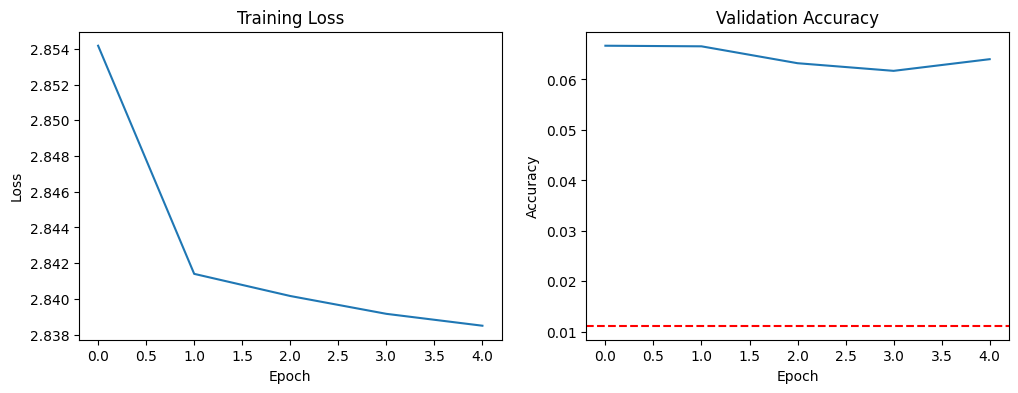

In [11]:
nltk.download('words')


# 4.2.1 Dataset Creation
class WordImageDataset(Dataset):
    def __init__(self, num_samples=100000, img_width=256, img_height=64):
        self.words_list = words.words()
        self.num_samples = num_samples
        self.img_width = img_width
        self.img_height = img_height
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
        # Create character to index mapping
        self.char_to_idx = {char: idx for idx, char in enumerate(string.ascii_letters + string.digits + string.punctuation)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        # Generate dataset
        self.data = self._generate_dataset()
        
    def _generate_image(self, word):
        # Create blank image
        image = Image.new('L', (self.img_width, self.img_height), color=255)
        draw = ImageDraw.Draw(image)
        
        # Load font
        font_size = 32
        try:
            font = ImageFont.truetype("Arial.ttf", font_size)
        except:
            font = ImageFont.load_default()
        
        # Calculate text position to center it
        bbox = draw.textbbox((0, 0), word, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        x = (self.img_width - text_width) // 2
        y = (self.img_height - text_height) // 2
        
        # Draw text
        draw.text((x, y), word, font=font, fill=0)
        return image
    
    def _generate_dataset(self):
        dataset = []
        words_subset = np.random.choice(self.words_list, self.num_samples)
        
        for word in words_subset:
            image = self._generate_image(word)
            dataset.append((image, word))
        return dataset
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, word = self.data[idx]
        image_tensor = self.transform(image)
        
        # Convert word to indices
        word_indices = torch.tensor([self.char_to_idx[c] for c in word])
        return image_tensor, word_indices

# 4.2.2 Architecture
class OCRModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=256):
        super(OCRModel, self).__init__()
        
        # CNN Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            
            nn.Dropout(0.25),
            # Continue CNN Encoder
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
        )
        
        # Calculate the size of flattened features
        self.feature_size = 512 * (256//16) * (64//16)  # After 4 max pooling layers
        
        # Linear layer to reduce feature dimension
        self.feature_reducer = nn.Linear(self.feature_size, hidden_size)
        
        # LSTM Decoder
        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.25
        )
        
        # Output layer
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, target_length):
        # CNN Encoding
        batch_size = x.size(0)
        features = self.encoder(x)
        features = features.view(batch_size, -1)  # Flatten
        features = self.feature_reducer(features)
        
        # Repeat features for each time step
        features = features.unsqueeze(1).repeat(1, target_length, 1)
        
        # LSTM Decoding
        outputs, _ = self.decoder(features)
        
        # Generate character predictions
        predictions = self.fc(outputs)
        return predictions


def collate_fn(batch):
    images, words = zip(*batch)
    
    # Stack images (already the same size)
    images = torch.stack(images, dim=0)
    
    # Pad sequences to the same length
    words = pad_sequence(words, batch_first=True, padding_value=0)  # Padding value of 0
    
    return images, words


# Training functions
def train_model(model, train_loader, val_loader, num_epochs=10, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            images, targets = images.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, targets.size(1))
            
            # Reshape for cross entropy
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            
            # loss = criterion(outputs, targets)
            # Mask out padding indices (assume padding index is 0)
            mask = (targets != 0).view(-1)  # Mask for non-padded values
            loss = criterion(outputs[mask], targets[mask])

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Validation
        accuracy = evaluate_model(model, val_loader, device)
        val_accuracies.append(accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Average Training Loss: {avg_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.4f}')
        
    return train_losses, val_accuracies

def evaluate_model(model, loader, device):
    model.eval()
    correct_chars = 0
    total_chars = 0
    
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images, targets.size(1))
            predictions = outputs.argmax(dim=-1)
            
            # Count correct characters
            correct_chars += (predictions == targets).sum().item()
            total_chars += targets.numel()
    
    return correct_chars / total_chars

def random_baseline(dataset, num_samples=1000):
    correct_chars = 0
    total_chars = 0
    
    for _ in range(num_samples):
        _, target = dataset[np.random.randint(len(dataset))]
        # Generate random prediction of same length
        pred = torch.randint(0, dataset.vocab_size, target.shape)
        correct_chars += (pred == target).sum().item()
        total_chars += len(target)
    
    return correct_chars / total_chars

# Visualization and prediction functions
def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 3*num_samples))
    
    with torch.no_grad():
        for i in range(num_samples):
            image, target = dataset[np.random.randint(len(dataset))]
            image_tensor = image.unsqueeze(0).to(device)
            
            # Get prediction
            outputs = model(image_tensor, target.size(0))
            pred_indices = outputs.squeeze(0).argmax(dim=-1).cpu()
            
            # Convert indices to characters
            target_word = ''.join([dataset.idx_to_char[idx.item()] for idx in target])
            pred_word = ''.join([dataset.idx_to_char[idx.item()] for idx in pred_indices])
            
            # Display
            axes[i].imshow(image.squeeze(), cmap='gray')
            axes[i].axis('off')
            axes[i].set_title(f'True: {target_word}\nPred: {pred_word}')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print(f"Using device: {device}")
    
    # Create dataset
    print("Creating dataset...")
    dataset = WordImageDataset(num_samples=100000)
    
    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    # Create data loaders
    batch_size = 32
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    # Calculate random baseline
    print("Calculating random baseline...")
    baseline_accuracy = random_baseline(dataset)
    print(f"Random Baseline Accuracy: {baseline_accuracy:.4f}")
    
    # Create and train model
    print("Creating model...")
    model = OCRModel(vocab_size=dataset.vocab_size).to(device)
    
    print("Starting training...")
    train_losses, val_accuracies = train_model(
        model, train_loader, val_loader, 
        num_epochs=5, device=device
    )
    
    # Plot training results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Random Baseline')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')